## Understanding DCLP3 Dataset
This notebook tries provides details on the structure of the DCLP3 dataset and makes suggestions how to process the data.

## The DCLP3 study

**Title**: The International Diabetes Closed Loop (iDCL) trial: Clinical Acceptance of 
the Artificial Pancreas - A Pivotal Study of t:slim X2 with Control-IQ Technology (DCLP3)

**Description**: The objective of the study is to assess efficacy and safety of a 
closed loop system (t:slim X2 with Control-IQ Technology) in a large randomized controlled trial.
    
**Devices**: t:slim X2 with Control-IQ and Dexcom G6 system

**Study Population**: Teens and adults aged 14 years or older

# Data
The study data folder is named **DCLP3 Public Dataset - Release 3 - 2022-08-04**
From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **Pump_BolusDelivered.txt**: List of pupm data downloaded (bolus data only)
* **Pump_BasalRateChange.txt**: List of pump data dowloaded (basal data only)
* **Pump_CGMGlucoseValue.txt**: List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## Pump_BolusDelivered
* **PtID**: Patient ID
* **DataDtTm**: Date-time of delivered insulin
* **BolusAmount**: the amount of bolus delivered **Need to find glossary to confirm if delivered or just programmed**
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 
* **BolusType**: The bolus insulin delivery type [Standard, Extended]
## Pump_BasalRateChange
* **PtID**: Patient ID
* **DataDtTm**: Date-time of basal rate change
* **CommandedBasalRate**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 
## Pump_CGMGlucoseValue
* **PtID**: Patient ID
* **DataDtTm**: Date-time of basal rate change
* **CGMValue**: CGM value in mg/dl
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 

## Questions
* Do we need to track DataDtTm_adjusted or can we rely on DataDtTm?
* How do we know if the bolus was fully completed?



In [1]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

## Load the data

In [13]:
filepath_data = '/Users/rachelbrandt/egvinsulin/data/raw/DCLP3 Public Dataset - Release 3 - 2022-08-04/Data Files'
df_bolus = pd.read_csv(os.path.join(filepath_data, 'Pump_BolusDelivered.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'BolusAmount', 'BolusType', 'DataDtTm_adjusted'])

df_basal = pd.read_csv(os.path.join(filepath_data, 'Pump_BasalRateChange.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'CommandedBasalRate', 'DataDtTm_adjusted'])
#load cgm data
df_cgm = pd.read_csv(os.path.join(filepath_data, 'Pump_CGMGlucoseValue.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DataDtTm', 'CGMValue', 'DataDtTm_adjusted'])

## Check for DateTimes without Time part

In [12]:
print('Date Time Counts:')
print('Bolus datetimes without time: ', len(df_bolus[df_bolus['DataDtTm'].str.len() <= 10]))
print('Basal datetimes without time: ', len(df_basal[df_basal['DataDtTm'].str.len() <= 10]))
print('CGM datetimes without time: ', len(df_cgm[df_cgm['DataDtTm'].str.len() <= 10])) 

Date Time Counts:
Bolus datetimes without time:  0
Basal datetimes without time:  0
CGM datetimes without time:  0


## inspecting the event counts

In [19]:
display(df_cgm.head());

print("overall data counts:")
print(df_cgm.count(),"\n");
print("unique patient ids: ", len(df_cgm.PtID.unique()))

,PtID,RecID,DataDtTm,CGMValue,DataDtTm_adjusted
0,22,1,2018-05-30 16:44:14,83,NaN
1,22,2,2018-05-30 16:59:15,117,NaN
2,22,3,2018-05-30 16:49:16,98,NaN
3,22,4,2018-05-30 16:54:16,111,NaN
4,22,5,2018-05-30 17:04:15,117,NaN


overall data counts:
PtID                 5677432
RecID                5677432
DataDtTm             5677432
CGMValue             5677432
DataDtTm_adjusted      85318
dtype: int64 

unique patient ids:  112


<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> We see that there are ~85k adjusted datetimes (~1.5% of the data).
</div>

In [20]:
display(df_bolus.head())

print("overall data counts:")
print(df_bolus.count(),"\n")
print("bolus types:")
print(df_bolus.BolusType.value_counts(),"\n")
print("unique patient ids: ", len(df_bolus.PtID.unique()))

,PtID,RecID,DataDtTm,BolusAmount,DataDtTm_adjusted,BolusType
0,79,10100,2018-04-29 04:45:44,0.645283,NaN,Standard
1,31,23863,2018-08-27 22:25:50,1.380000,NaN,Standard
2,88,111267,2018-06-12 08:16:17,2.000000,NaN,Standard
3,6,164032,2018-06-17 13:54:45,5.000000,NaN,Standard
4,139,191368,2019-01-01 21:03:02,9.000000,NaN,Standard


overall data counts:
PtID                 221292
RecID                221292
DataDtTm             221292
BolusAmount          221292
DataDtTm_adjusted      3107
BolusType            221292
dtype: int64 

bolus types:
BolusType
Standard    217035
Extended      4257
Name: count, dtype: int64 

unique patient ids:  125


<div class="alert alert-block alert-warning">
<b>Extended Boluses:</b> There are 4257 extended boluses (~1.9% of the boluses). We do not have any data on how the boluses were extended. Users can set a % of the bolus to be delivered immediately and the remaining % will be delivered over a period of time the user sets. The time has to be <= 2 hours. The default extended bolus is 50% up front and 50% over 2 hours
</div>

In [21]:
display(df_basal.head())

print("overall data counts:")
print(df_basal.count(),"\n")
print("unique patient ids: ", len(df_basal.PtID.unique()))

,PtID,RecID,DataDtTm,CommandedBasalRate,DataDtTm_adjusted
0,10,3,2018-04-04 12:52:41,2.00,NaN
1,10,4,2018-04-04 12:57:41,0.00,NaN
2,12,7,2018-05-17 12:43:45,0.55,NaN
3,12,8,2018-05-17 12:48:45,0.00,NaN
4,14,11,2018-07-08 14:49:22,1.10,NaN


overall data counts:
PtID                  2610772
RecID                 2610772
DataDtTm              2610772
CommandedBasalRate    2610772
DataDtTm_adjusted       38382
dtype: int64 

unique patient ids:  125


### Total Patient IDs with CGM, Basal and Bolus data

In [38]:
basal_ids = df_basal.PtID.unique()
bolus_ids = df_bolus.PtID.unique()
cgm_ids = df_cgm.PtID.unique()

from functools import reduce
total_ids = reduce(np.intersect1d, (basal_ids, bolus_ids, cgm_ids))

print('Total PtIDs with all forms of data: ', len(total_ids))

Total PtIDs with all forms of data:  112


### Distribution of Commanded Basal Rates

Commanded Basal Rate info: 
count    2.610772e+06
mean     1.296549e+00
std      1.201852e+00
min      0.000000e+00
25%      4.470000e-01
50%      9.660000e-01
75%      1.758000e+00
max      1.500000e+01
Name: CommandedBasalRate, dtype: float64


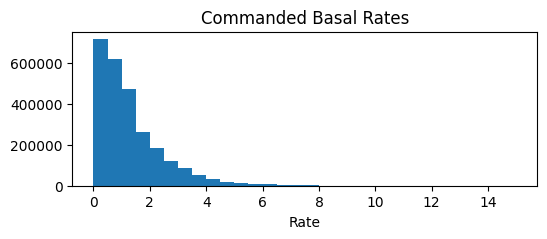

In [35]:
print('Commanded Basal Rate info: ')
print(df_basal.CommandedBasalRate.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Rate"); plt.title("Commanded Basal Rates")
plt.hist(df_basal.CommandedBasalRate, bins=np.arange(min(df_basal.CommandedBasalRate), max(df_basal.CommandedBasalRate) + 0.5, 0.5));

<div class="alert alert-block alert-info"> The maximum basal rate reached 15 U/h. This equates to 1.25 U every 5 minutes. This happend 17 times. Only 0.12% of commanded basal rates are > 8U/hr (0.67U per 5 min) </div>

### Distribution of Bolus Amounts

Commanded Basal Rate info: 
count    221292.000000
mean          2.989165
std           3.565708
min           0.000000
25%           0.801132
50%           1.666667
75%           3.890000
max          25.000002
Name: BolusAmount, dtype: float64


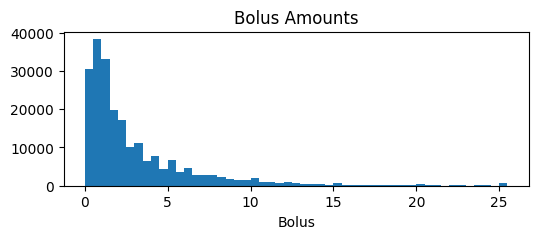

In [36]:
print('Commanded Basal Rate info: ')
print(df_bolus.BolusAmount.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Bolus"); plt.title("Bolus Amounts")
plt.hist(df_bolus.BolusAmount, bins=np.arange(min(df_bolus.BolusAmount), max(df_bolus.BolusAmount) + 0.5, 0.5));

<div class="alert alert-block alert-warning">
Need to find glossary to confirm: We do not have any information on if this is the programmed bolus or the delivered bolus
</div>